<a href="https://colab.research.google.com/github/srilamaiti/spring_2023_w266_final_project_heesuk_iris_srila/blob/main/srila/bertweet_ell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing new libraries**

In [1]:
#!pip install nltk
#!pip install wordcloud
#!pip3 install tokenizers
#!pip install sentencepiece
!pip install transformers
!pip install emoji==0.6.0
!pip install scikit-multilearn
!pip install iterative-stratification
!pip install tensorflow==2.11.0
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49732 sha256=2d5ff0412e3f754ccb52c510326d54d6c262edbff69806fe374f3de599406a0f
  Stored in directory: /root/.cache/pip/wheels/70/2a/7f/1a0012c86b1061c6ee2ed9568b1f830f857a51e8e416452af2
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 4.0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Importing libraries**

In [2]:
import transformers
print(f'transformers version: {transformers.__version__}')
from transformers import logging as hf_logging
from transformers import BertTokenizer, TFBertModel
from transformers import TFAutoModel, AutoTokenizer
hf_logging.set_verbosity_error()
'''
import nltk
from nltk.tokenize import sent_tokenize
import spacy      
from spacy import displacy
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
nltk.download('punkt')
'''
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from transformers import RobertaTokenizer, TFRobertaModel
ROBERTA_MODEL_CHKPT = "roberta-base"
BERTWEET_MODEL_CHKPT = "vinai/bertweet-base"

# Other required libraries
import math
import os
import pandas as pd
import numpy as np
import re
import copy
import sys
import gc

# data visualization
from matplotlib import cm
import matplotlib.pyplot as plt
from IPython.display import Image

# others
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import set_link_color_palette
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

# distances
from scipy.spatial.distance import pdist, squareform

import warnings
warnings.filterwarnings("ignore")

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.models import load_model

import torch
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
print(tf.__version__)

transformers version: 4.27.4
2.11.0


# **General functions**

## **Rounding Off to Custom Decimal Places**

In [3]:
def roundPartial(value, resolution):
    return round (value / resolution) * resolution

## **Set parameters**

In [4]:
def set_config_param(seed = 99):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_columns', None)
    
    
set_config_param(20230214)

## **Plot loss and accuracy**

In [5]:
def plot_loss_accuracy(history, col_list):
    fig, ax = plt.subplots(2, 6, figsize=(16, 6), sharex='col', sharey='row')
    fig.tight_layout(pad=5.0)
    for idx, col in enumerate(col_list):

        ax[0, idx].plot(history[col + '_loss'], lw=2, color='darkgoldenrod')
        ax[0, idx].plot(history['val_' + col + '_loss'], lw=2, color='indianred')
        #ax[0, idx].legend(loc='center left')
        ax[0, idx].legend(['Train', 'Validation'], fontsize=5)
        ax[0, idx].set_xlabel('Epochs', size=10)
        ax[0, idx].set_title('Loss: ' + col)

        ax[1, idx].plot(history[col + '_accuracy'], lw=2, color='darkgoldenrod')
        ax[1, idx].plot(history['val_' + col + '_accuracy'], lw=2, color='indianred')
        #ax[0, idx].legend(loc='center left')
        ax[1, idx].legend(['Train', 'Validation'], fontsize=5)
        ax[1, idx].set_xlabel('Epochs', size=10)
        ax[1, idx].set_title('Accuracy: ' + col)

## **Plot Loss and other KPI specified**

In [6]:
def custom_plot(df, kpi_name, kpi_string):
    x_arr = np.arange(len(df['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, df['loss'], '-o', label = 'Train loss')
    ax.plot(x_arr, df['val_loss'], '--<', label = 'Validation loss')
    ax.legend(fontsize = 15)
    ax.set_xlabel('Epoch', size = 15)
    ax.set_ylabel('Loss', size = 15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, df[kpi_name], '-o', label = 'Train ' + kpi_string)
    ax.plot(x_arr, df['val_' + kpi_name], '--<', label = 'Validation ' + kpi_string)
    ax.legend(fontsize = 15)
    ax.set_xlabel('Epoch', size = 15)
    ax.set_ylabel('Accuracy', size = 15)
    #ax.set_ylim(0,1)
    plt.show()

## **Text Encode**

In [7]:
def text_encode(texts, tokenizer, max_len):
    input_ids = []
    # token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, 
                          max_length = max_len, 
                          truncation = True, 
                          padding = 'max_length',
                          add_special_tokens = True)
        input_ids.append(token['input_ids'])
        # token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(attention_mask)

## **Custom metric**

In [8]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis = 1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis = -1, keepdims = True)

## **Build Base Model**

In [30]:
def build_regression_model(loss = 'MCRMSE',
                           model_name = 'Roberta', 
                           dense_dim = 6, 
                           MAX_LEN = 512,
                           learning_rate = 1e-5,
                           dropout = .1,
                           number_of_hidden_layers = 1,
                           hidden_layer_node_count = 64,
                           retrain_layer_count = 0):
    
    # Define inputs
    input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'input_ids')
    attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'attention_masks')
    
    if model_name == 'Roberta':
        model_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_CHKPT)
        model = TFRobertaModel.from_pretrained(ROBERTA_MODEL_CHKPT)
    elif model_name == 'Bertweet':
        model_tokenizer = AutoTokenizer.from_pretrained(BERTWEET_MODEL_CHKPT)
        model = TFRobertaModel.from_pretrained(BERTWEET_MODEL_CHKPT)

    # Adjust the trainable layer weights based on retrain_layer_count
    # If retrain_layer_count is 0, then base model is frozen.
    # If retrain_layer_count is 12, then the entire base model is trainable.
    # And that implies that all the pretrained weights are lost and it relearns
    # from the input data.
    # If retrain_layer_count is between 1 and 11, then the last n layers of
    # the pretrained model retrained.
    if retrain_layer_count == 0:
        # The pretained model is frozen
        model.trainable = False           

    elif retrain_layer_count == 12:  
        # The pretrained model is retrained thru all layers.       
        model.trainable = True     

    else:    
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layer_list = []
        model.trainable = False  
        for retrain_layer_number in range(retrain_layer_count):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layer_list.append(layer_code)
        
        print('Retrain layers: \n', retrain_layer_list)
        #model.compile()
        print(f"Number of trainable parameters : {count_params(model.trainable_weights)}")
        print(f"Number of non-trainable parameters : {count_params(model.non_trainable_variables)}")
        for weight in model.weights:
            weight._trainable = False
            #print("***", layer.name, layer._trainable)
            if 'layer_' in weight.name and weight.name.split(".")[1].split("/")[0] in retrain_layer_list:
                weight._trainable = True
                print("$$$", weight.name, weight._trainable)
            elif 'layer_' not in weight.name :
                weight._trainable = True
                print("###", weight.name, weight._trainable)
        model.compile()

        for weight_details in model.weights:
            print(weight_details.name, weight_details.trainable)
    print(f"Number of trainable parameters : {count_params(model.trainable_weights)}")
    print(f"Number of non-trainable parameters : {count_params(model.non_trainable_variables)}")
                
    # Insert pretrained model layer
    pretrained_transformer = model([input_ids, attention_masks])

    # Get the CLS output off the pretrained model
    cls_token = pretrained_transformer[0][:, 0, :]

    # Append the hidden layer and dropout layer
    layer_list = []
    for layer in range(number_of_hidden_layers):
        if layer == 0:
            hidden_layer = tf.keras.layers.Dense(units      = hidden_layer_node_count
                                               , activation = 'relu'
                                               , name       = 'hidden_layer_' + str(layer + 1)
                                                )(cls_token)
        else:
            hidden_layer = tf.keras.layers.Dense(units      = hidden_layer_node_count
                                               , activation = 'relu'
                                               , name       = 'hidden_layer_' + str(layer + 1)
                                            )(layer_list[-1])
        layer_list.append(hidden_layer)
        dropout_layer = tf.keras.layers.Dropout(dropout, 
                                                name = 'dropout_layer_' + str(layer + 1)
                                               )(hidden_layer) 
        layer_list.append(dropout_layer)

    # Add the output layer
    output = tf.keras.layers.Dense(6,)(layer_list[-1])

    # Build the final model
    regression_model = tf.keras.Model(inputs = [input_ids, attention_masks], outputs = output)
    
    # Model compile
    if loss == 'MCRMSE':
        regression_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                                 loss      = MCRMSE,
                                 metrics   = MCRMSE
                                )
    
    print(regression_model.summary())
    keras.utils.plot_model(regression_model, 
                           show_shapes = False, 
                           show_dtype = False, 
                           show_layer_names = True, 
                           dpi = 90)
    return regression_model

'''
regression_model = build_regression_model(
                       loss = 'MCRMSE',
                       model_name = 'Roberta', 
                       dense_dim = 6, 
                       MAX_LEN = 512,
                       learning_rate = 1e-5,
                       dropout = .1,
                       number_of_hidden_layers = 1,
                       hidden_layer_node_count = 64,
                       retrain_layer_count = 6)
'''

"\nregression_model = build_regression_model(\n                       loss = 'MCRMSE',\n                       model_name = 'Roberta', \n                       dense_dim = 6, \n                       MAX_LEN = 512,\n                       learning_rate = 1e-5,\n                       dropout = .1,\n                       number_of_hidden_layers = 1,\n                       hidden_layer_node_count = 64,\n                       retrain_layer_count = 6)\n"

In [10]:
def model_fit(model, 
              df_train, 
              train_indices,
              val_indices,
              model_name = 'Roberta', 
              MAX_LEN = 512,
              epochs = 5,
              batch_size = 4,
              validation_split = .2):
  
    # Building the tokenizer for the given model
    if model_name == 'Roberta':
        tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_CHKPT)
    elif model_name == 'Bertweet':
        tokenizer = AutoTokenizer.from_pretrained(BERTWEET_MODEL_CHKPT)
        
    train_encoded_input_ids, train_encoded_attention_masks = text_encode(df_train.iloc[list(train_indices)]['full_text'], tokenizer, MAX_LEN)
    val_encoded_input_ids, val_encoded_attention_masks = text_encode(df_train.iloc[list(val_indices)]['full_text'], tokenizer, MAX_LEN)

    y_train = np.array(df_train.iloc[list(train_indices)][label_cols], dtype = "float32")
    y_val = np.array(df_train.iloc[list(val_indices)][label_cols], dtype = "float32")
    
    hist = model.fit([train_encoded_input_ids, train_encoded_attention_masks],
                     y_train,
                     validation_data = ([val_encoded_input_ids, val_encoded_attention_masks], 
                                        y_val
                                       ),
                     batch_size = batch_size,        
                     epochs = epochs
                    )

    df_history = pd.DataFrame(hist.history)
    return df_history

In [11]:
def build_base_model(model_layer, learning_rate, dense_dim = 6):
    
    #define inputs
    input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'input_ids')
    attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'attention_masks')
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids, attention_masks])
    
    #choose only last hidden-state
    x = transformer_layer[1]
    output = tf.keras.layers.Dense(dense_dim)(x)
    #output = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x)
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)

    model.compile(tf.keras.optimizers.Adam(learning_rate), loss = mse_loss, metrics = mse_metrics)
    
    return model

## **Build a model with custom loss**

In [12]:
def build_base_model_with_custom_loss(model_layer, learning_rate, dense_dim = 6):
    
    #define inputs
    input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'input_ids')
    attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'attention_masks')
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids, attention_masks])
    
    #choose only last hidden-state
    x = transformer_layer[1]
    output = tf.keras.layers.Dense(dense_dim)(x)
    #output = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x)
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)

    model.compile(tf.keras.optimizers.Adam(learning_rate), loss = MCRMSE, metrics = MCRMSE)
    
    return model

##**Evaluate**

In [13]:
def evaluate_model(model, y_test, test_encoded_input_ids, test_encoded_attention_masks):
    score = model.evaluate([test_encoded_input_ids, test_encoded_attention_masks], 
                           y_test
                          ) 
    print('\nTest Loss : {:.2f}%'.format(score[0]))
    print('\nTest Accuracy :  {:.2f}%'.format(score[1]))
    return score[0], score[1]

## **Predict**

In [14]:
def predict_model(model, df_test, test_encoded_input_ids, test_encoded_attention_masks, label_cols):
    predictions = model.predict([test_encoded_input_ids, test_encoded_attention_masks])
    df_predictions = pd.DataFrame(predictions, columns=['pred_' + c for c in label_cols])
    for col in label_cols:
        df_predictions['transformed_pred_' + col] = df_predictions['pred_' + col].apply(lambda x : roundPartial(x, .5))
    df_comparison = pd.merge(df_test, df_predictions, left_index = True, right_index = True)
    return df_predictions, df_comparison

## **Plot Model Structure**

In [15]:
def plot_model_structure(model):
    keras.utils.plot_model(model, show_shapes = False, show_dtype = False, show_layer_names = True, dpi = 90)

# **Read input files**

In [20]:
input_train_df = pd.read_csv('train.csv')
input_test_df = pd.read_csv('test.csv')
# Cleaning up full_text : Removing tabl and carriage return characters
input_train_df['full_text'] = input_train_df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex = True)
input_test_df['full_text'] = input_test_df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex = True)

label_cols = input_train_df.columns[2:]
input_train_df['score_sum'] = np.sum(input_train_df[label_cols], axis = 1)
pred_col_list = ['transformed_pred_' + col for col in label_cols]

orig_train_df = copy.deepcopy(input_train_df)
orig_train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,score_sum
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,20.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,14.5
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5,18.0
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,27.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,16.5


As we do not have labels for our test data, we are repurposing our training data by splitting it into 80:20 ratio.

In [21]:
# shuffling them back again
shuffle = np.random.permutation(np.arange(orig_train_df.shape[0]))
orig_train_df = orig_train_df.iloc[shuffle]

# Splitting the data in 80:20 split
split = (0.8, 0.2)
splits = np.multiply(len(orig_train_df), split).astype(int)
df_train, df_test = orig_train_df[ : splits[0]], orig_train_df[splits[0] : ]
y_test = np.array(df_test[label_cols], dtype = "float32")

print(f"Length of train data : {len(df_train)}")
print(f"Length of test data : {len(df_test)}")

Length of train data : 3128
Length of test data : 783


# **Clustering**

In [22]:
df_rating = copy.deepcopy(df_train[label_cols])
rating_values_array = np.array(df_rating[label_cols])

# standardize
sc = StandardScaler()
rating_values_array_std = sc.fit(rating_values_array).transform(rating_values_array)

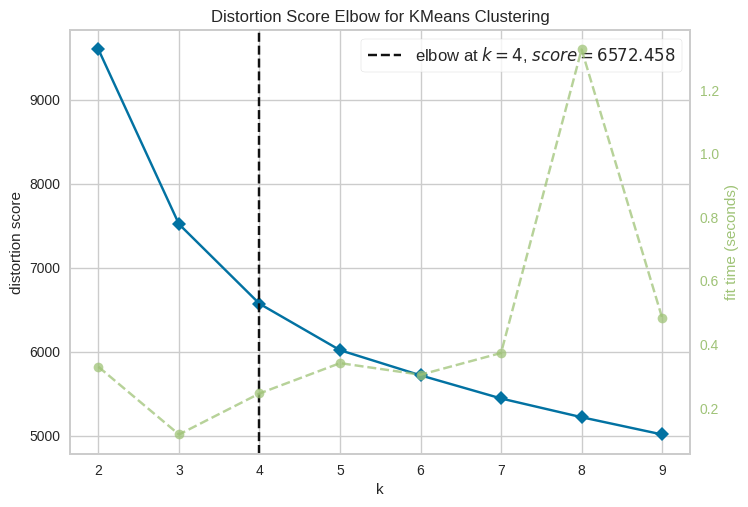

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(rating_values_array_std)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Here is how the Elbow / SSE Plot would look like. As per the plot given below, for n_clusters = 3 that represents the elbow you start seeing diminishing returns by increasing k. The line starts looking linear.

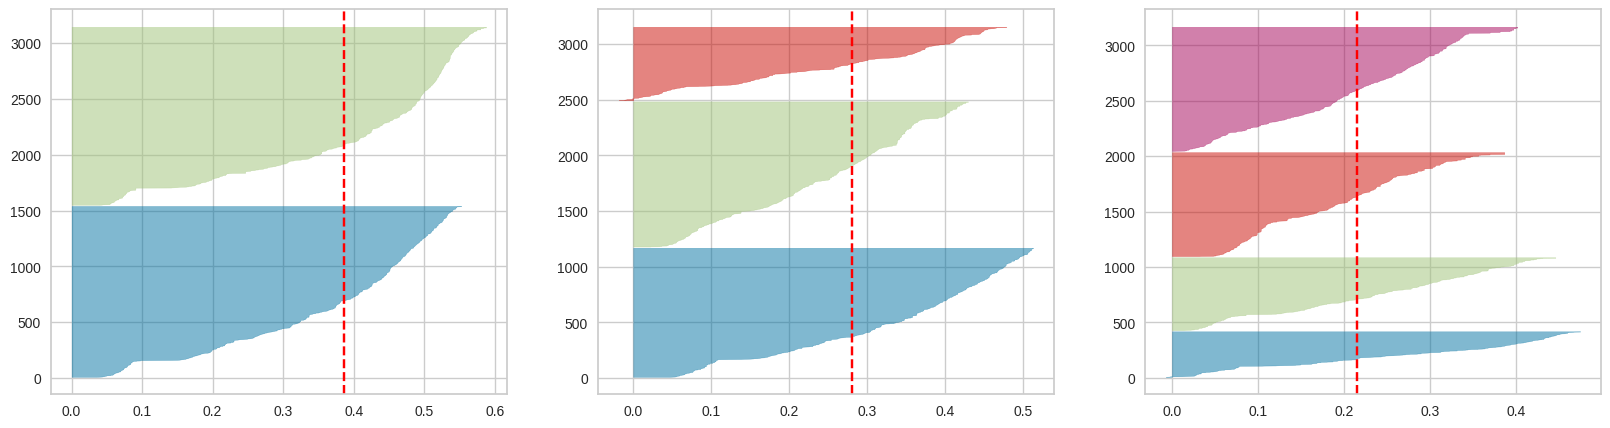

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
for idx, i in enumerate([2, 3, 4]):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    #q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[idx])
    visualizer.fit(rating_values_array_std) 

Given above, the Silhouette plot for n_clusters = 3 looks to be most appropriate than others as it stands well against all the three measuring criteria (scores below average Silhouette score, Wide fluctuations in the size of the plot, and non-uniform thickness).

In [25]:
km_base = KMeans(n_clusters=3,
           #init='random',
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=1234)

# predict k-means classes
y_km_base = km_base.fit_predict(rating_values_array_std)

# Assigning cluster value to the datafarme
df_train['cluster_id'] = y_km_base

In [26]:
df_train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,score_sum,cluster_id
1960,93EF5F755313,To who may concern. The Former British Prime ...,3.5,3.0,3.5,3.5,2.5,2.5,18.5,1
52,04659704890C,Having a good attitude is important if we want...,2.5,3.0,3.0,3.0,3.5,3.0,18.0,1
3570,F1933BF43F45,I agree with this idea and I think it's a good...,3.5,3.0,3.0,3.5,3.5,3.5,20.0,1
3081,DAF9AC30424E,The school day should not be extended even mor...,3.5,3.0,2.5,2.5,3.5,3.0,18.0,1
2738,C972C565A819,Do you want to see a temple made with gold? I ...,3.5,3.0,3.0,2.5,2.5,3.0,17.5,1


We can see that an increase in *k* is associated with a decrease in the within-cluster SSE. 

This is because the examples are closer to the centroid they assigned to.

**The elbow solution**: the optimal *k* is where the within-cluster SSE begings to increase most rapidly.

For this particular example the elbow is at *k=2* so we started with a good number of clusters.


In [27]:
df_train_cluster0 = df_train[df_train.cluster_id == 0]
df_train_cluster1 = df_train[df_train.cluster_id == 1]
df_train_cluster2 = df_train[df_train.cluster_id == 2]

print(f"Length of cluster 0 : {len(df_train_cluster0)}")
print(f"Length of cluster 1 : {len(df_train_cluster1)}")
print(f"Length of cluster 2 : {len(df_train_cluster2)}")

Length of cluster 0 : 1161
Length of cluster 1 : 1306
Length of cluster 2 : 661


In [28]:
print(f"Min and max score in cluster 0 are : {np.min(df_train_cluster0['score_sum'])} and {np.max(df_train_cluster0['score_sum'])}")
print(f"Min and Max score in cluster 1 are : {np.min(df_train_cluster1['score_sum'])} and {np.max(df_train_cluster1['score_sum'])}")
print(f"Min and Max score in cluster 2 are : {np.min(df_train_cluster2['score_sum'])} and {np.max(df_train_cluster2['score_sum'])}")

Min and max score in cluster 0 are : 6.0 and 17.0
Min and Max score in cluster 1 are : 17.5 and 21.5
Min and Max score in cluster 2 are : 21.5 and 30.0


The cluster is divided based on the distribution of the data. Low-scores are in one bucket, medium scores are placed in another and top scrores are placed in the higher bucket.

# **Model parameter setup**

In [18]:
set_config_param()

# Fixed parameters
dense_dim = 6
number_of_splits = 5
random_state = 2023
MAX_LEN = 128
mse_loss = tf.keras.losses.mse
mse_metrics = tf.keras.metrics.mse

# Variable parameters
epochs = 5
batch_size = 4
learning_rate = 1e-5
validation_split = .2
dropout = .1
number_of_hidden_layers = 1
hidden_layer_node_count = 64
retrain_layer_count = 0

# Variable parameter dictionary
param_list = [
                 # Completely frozen base layer
                 {'epochs'                  : 5,
                  'batch_size'              : 4,
                  'learning_rate'           : 1e-5,
                  'validation_split'        : .2,
                  'dropout'                 : .1,
                  'number_of_hidden_layers' : 1,
                  'hidden_layer_node_count' : 64,
                  'retrain_layer_count'     : 0
                 },
                 # Partially frozen base layer
                 {'epochs'                  : 5,
                  'batch_size'              : 4,
                  'learning_rate'           : 1e-5,
                  'validation_split'        : .2,
                  'dropout'                 : .1,
                  'number_of_hidden_layers' : 1,
                  'hidden_layer_node_count' : 64,
                  'retrain_layer_count'     : 6
                 },
                 # Completely unfrozen base layer
                 {'epochs'                  : 5,
                  'batch_size'              : 4,
                  'learning_rate'           : 1e-5,
                  'validation_split'        : .2,
                  'dropout'                 : .1,
                  'number_of_hidden_layers' : 1,
                  'hidden_layer_node_count' : 64,
                  'retrain_layer_count'     : 12
                 },
             ]

# **Model building**

Original test data is very limited, there are only 3 records and it does not have labels to test. So we decided to repurpose the given train data to split into train, test and validation sets.

We take the initial input train set and split into train and test set with 8:2 ratio.

The train part is then going thru k fold cross validation and get tested on validation set and final test is done on the test set. Final test accuracy will be the average MCRMSE score across k-folds.



In [ ]:
# Combining the two clusters' data
df_train = pd.concat([df_train_cluster0, df_train_cluster1, df_train_cluster2])

# shuffling them back again
shuffle = np.random.permutation(np.arange(df_train.shape[0]))
df_train = df_train.iloc[shuffle]


MCRMSE_list = []

'''
rating_cluster has two values 0 and 1.
We are doing k fold with stratification using rating_cluster.
We introduced this new column to split on as as our data ouput is multi class
and multi label with continuous values and traditional k fold split does not
support that.
This new column will help us to see if our model is performing better for which 
group : above or below average.
'''
for idx, param_entry in enumerate(param_list):
    
    epoch_val = param_entry['epochs']
    batch_size_val = param_entry['batch_size']
    learning_rate_val = param_entry['learning_rate']
    validation_split_val = param_entry['validation_split']
    dropout_val = param_entry['dropout']
    number_of_hidden_layers_val = param_entry['number_of_hidden_layers']
    hidden_layer_node_count_val = param_entry['hidden_layer_node_count']
    retrain_layer_count_val = param_entry['retrain_layer_count']

    for kfold, (train_indices, val_indices) in enumerate(StratifiedKFold(n_splits     = number_of_splits, 
                                                                         shuffle      = True, 
                                                                         random_state = random_state
                                                                         ).split(df_train['cluster_id'].values.tolist(), 
                                                                                 df_train['cluster_id'].values.tolist()
                                                                                )
                                                         ):
        print("************************")
        print(f"Iteration : {idx + 1}")
        print("Parameters...")
        print(f"Epochs : {epoch_val}")
        print(f"Batch size : {batch_size_val}")
        print(f"Learning rate : {learning_rate_val}")
        print(f"Validation split : {validation_split_val}")
        print(f"Dropout : {dropout_val}")
        print(f"Number of hidden layers : {number_of_hidden_layers_val}")
        print(f"Hidden layer node count : {hidden_layer_node_count_val}")
        print(f"Retrain layer count : {retrain_layer_count_val}")
        print("************************")
        print(f"k-fold : {kfold + 1}")
        print(f"length of train data : {len(train_indices)}")
        print(f"length of validation data : {len(val_indices)}")
        print("************************")
        
        # Model building
        print("Building model...")
        regression_model = build_regression_model(loss                    = 'MCRMSE',
                                                  model_name              = 'Bertweet', 
                                                  dense_dim               = dense_dim, 
                                                  MAX_LEN                 = MAX_LEN,
                                                  learning_rate           = learning_rate_val,
                                                  dropout                 = dropout_val,
                                                  number_of_hidden_layers = number_of_hidden_layers_val,
                                                  hidden_layer_node_count = hidden_layer_node_count_val,
                                                  retrain_layer_count     = retrain_layer_count_val
                                                 )
        
        # Model fitting
        print("Fitting model...")
        df_history = model_fit(regression_model, 
                               df_train, 
                               train_indices,
                               val_indices,
                               model_name = 'Bertweet', 
                               MAX_LEN = MAX_LEN,
                               epochs = epoch_val,
                               batch_size = batch_size_val,
                               validation_split = validation_split_val
                              )
        print(df_history.T)

        print("Plotting loss and MCRMSE...")
        custom_plot(df_history, 'MCRMSE', 'MCRMSE')

        # Prep for model evaluation with test data
        print("Evaluating mode...")
        roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL_CHKPT)
        test_encoded_input_ids, test_encoded_attention_masks = text_encode(df_test['full_text'], 
                                                                           roberta_tokenizer, 
                                                                           MAX_LEN
                                                                          )
        # Model evaluation
        test_loss, test_accuracy = evaluate_model(regression_model, 
                                                  y_test, 
                                                  test_encoded_input_ids, 
                                                  test_encoded_attention_masks
                                                 )

        # Model prediction
        print("Model prediction...")
        df_prediction, df_comparison = predict_model(regression_model, 
                                                     df_test, 
                                                     test_encoded_input_ids, 
                                                     test_encoded_attention_masks, 
                                                     label_cols)

        print("Plotting model structure...")
        keras.utils.plot_model(regression_model, 
                               show_shapes      = False, 
                               show_dtype       = False, 
                               show_layer_names = True, 
                               dpi              = 90
                              )

        print("Appending to kpi list...")
        MCRMSE_list.append({'model_name'                  : 'roberta-base',
                            'iteration'                   : idx + 1,
                            'epoch_val'                   : epoch_val,
                            'batch_size_val'              : batch_size_val,
                            'learning_rate_val'           : learning_rate_val,
                            'validation_split_val'        : validation_split_val,
                            'dropout_val'                 : dropout_val,
                            'number_of_hidden_layers_val' : number_of_hidden_layers_val,
                            'hidden_layer_node_count_val' : hidden_layer_node_count_val,
                            'retrain_layer_count_val'     : retrain_layer_count_val,
                            'fold'                        : kfold + 1, 
                            'train_loss'                  : df_history.iloc[-1][0],
                            'train_accuracy'              : df_history.iloc[-1][1],
                            'val_loss'                    : df_history.iloc[-1][2],
                            'val_accuracy'                : df_history.iloc[-1][2],
                            'test_loss'                   : test_loss,
                            'test_accuracy'               : test_accuracy
                           }
                          )
        # Saving the model
        print("Saving the model...")
        model_file_name = 'regression_model_iter_' + str(idx + 1) + '_kfold_' + str(kfold + 1) + ".h5"
        regression_model.save(model_file_name)

************************
Iteration : 1
Parameters...
Epochs : 5
Batch size : 4
Learning rate : 1e-05
Validation split : 0.2
Dropout : 0.1
Number of hidden layers : 1
Hidden layer node count : 64
Retrain layer count : 0
************************
k-fold : 1
length of train data : 2502
length of validation data : 626
************************
Building model...


Number of trainable parameters : 0
Number of non-trainable parameters : 134899968


In [ ]:
kpi_col_list = ['model_name',
                'iteration',
                'epoch_val',
                'batch_size_val',
                'learning_rate_val',
                'validation_split_val',
                'dropout_val',
                'number_of_hidden_layers_val',
                'hidden_layer_node_count_val',
                'retrain_layer_count_val',
                'fold', 
                'train_loss', 
                'train_accuracy', 
                'val_loss', 
                'val_accuracy', 
                'test_loss', 
                'test_accuracy'
               ]
df_MCRMSE = pd.DataFrame(MCRMSE_list, columns = kpi_col_list)    
df_MCRMSE.to_csv("kpi_stats.csv", index = False)
df_MCRMSE    

In [ ]:
print("Average test accuracy and loss...")
df_MCRMSE.groupby(['model_name', 'iteration']).agg({'test_loss'      : [np.mean, np.min, np.max],  
                                                    'test_accuracy'  : [np.mean, np.min, np.max] 
                                                   }
                                                  )